# APIs

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import root_mean_squared_error

# %pip install pypalettes
import pypalettes
from pypalettes import load_cmap

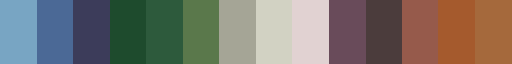

In [50]:
cmap = load_cmap('fleurs_dans_un_vase_de_cristal')
cmap

In [51]:
print(cmap.colors)

['#78A5C3FF', '#4B6996FF', '#3C3C5AFF', '#1E4B2DFF', '#2D5A3CFF', '#5A784BFF', '#A5A596FF', '#D2D2C3FF', '#E1D2D2FF', '#694B5AFF', '#4B3C3CFF', '#965A4BFF', '#A55A2DFF', '#A5693CFF']


# Approach

### Problem Statement
Build a ML model to predict recommended sale price for a used car based on past sales trends

### Model Evaluation

The submitted model will be evaluated using Root Mean Squared Error (RMSE) on a hidden test set.

### Business Context
To be used by individuals to set selling price for their own cars while selling. This will enable them to make an informed decision and set a balanced price for the car, neither too high nor too low.

### Model

This is a regression task. Our task is to predict 'Price'.

Plan:
- Check missing values. Impute if required.
- Handle categorical variables.
- Scaling since we will start with Linear Regression as the Baseline.
- Univariate and Bivariate Analysis
- Check for outliers
- Correlation Analysis
- Feature Engineering
- Feature Selection
- Hyperparameter Tuning

# Data Exploration

## Loading training data

In [9]:
train_csv = pd.read_csv('data/train.csv')

In [10]:
train_csv.shape

(7478, 33)

In [11]:
train_csv.head()

,Id,Scraped_Time,Condition,Car Make,Model,Trim,Year,Kilometers,Body Type,Number of Seats,...,Neighborhood,Category,Subcategory,Interior Options,Exterior Options,Technology Options,Description_Score,Battery Capacity,Battery Range,Price
0,1,2025-02-07 01:58:30,Used,Toyota,Prius,Prius,2010,"20,000 - 29,999",Sedan,5,...,Abu Alanda,Cars and Bikes,Cars For Sale,"Airbags, Air Condition, Electric Seat Control,...","Panoramic Roof, Electrically Folding Mirrors, ...","Remote Start, Cruise Control, Radar, Navigatio...",فحص كامل,NaN,NaN,9350.0
1,2,2025-02-07 02:27:18,Used,Honda,Civic,Standard,2000,"+200,000",Sedan,4,...,Abu Alanda,Cars and Bikes,Cars For Sale,"Airbags, Center Lock, Air Condition, Alarm Sys...","Rim Wheels, Electric Mirrors",ABS Brakes,NaN,NaN,NaN,4200.0
2,3,2025-02-07 11:55:06,Used,Mitsubishi,Pajero,GLS,2015,"110,000 - 119,999",SUV,7,...,Sports City,Cars and Bikes,Cars For Sale,"Airbags, Steering Wheel Controls, Electric Win...","Spare Tyre, Rim Wheels, Electrically Folding M...","Media Screen, ABS Brakes, Rear Camera, Tractio...",NaN,NaN,NaN,8900.0
3,4,2025-02-07 13:25:57,Used,Nissan,Murano,SE,2005,"180,000 - 189,999",Sedan,5,...,Jabal Al Amera Rahma,Cars and Bikes,Cars For Sale,"Electric Seat Control, Air Condition, AUX / US...","Electrically Folding Mirrors, Electric Mirrors...","Traction Control, Cruise Control, Tyre Pressur...",فحص كامل,NaN,NaN,5500.0
4,5,2025-02-07 12:57:00,Used,Hyundai,H1,GL,2003,"140,000 - 149,999",Bus - Van,5,...,Al Souq,Cars and Bikes,Cars For Sale,"Steering Wheel Controls, Electric Windows, Cen...","Rear Sensors, Electric Mirrors, Daytime Runnin...","Bluetooth, Auto Lock System, Traction Control",NaN,NaN,NaN,5000.0


In [12]:
updated_col_names = ['Id', 'Scraped_Time', 'Condition', 'Car_Make', 'Model', 'Trim', 'Year',
       'Kilometers', 'Body_Type', 'Num_of_Seats', 'Fuel', 'Transmission',
       'Engine_Size_cc', 'Exterior_Color', 'Interior_Color',
       'Regional_Specs', 'Car_License', 'Insurance', 'Car_Customs',
       'Body_Condition', 'Paint', 'Payment_Method', 'City', 'Neighborhood',
       'Category', 'Subcategory', 'Interior_Options', 'Exterior_Options',
       'Technology_Options', 'Description_Score', 'Battery_Capacity',
       'Battery_Range', 'Price']

In [13]:
original_col_names = list(train_csv.columns)

In [14]:
cols_map = {}
for old, new in zip(original_col_names, updated_col_names):
    cols_map[old] = new.lower()
print(cols_map)   

{'Id': 'id', 'Scraped_Time': 'scraped_time', 'Condition': 'condition', 'Car Make': 'car_make', 'Model': 'model', 'Trim': 'trim', 'Year': 'year', 'Kilometers': 'kilometers', 'Body Type': 'body_type', 'Number of Seats': 'num_of_seats', 'Fuel': 'fuel', 'Transmission': 'transmission', 'Engine Size (cc)': 'engine_size_cc', 'Exterior Color': 'exterior_color', 'Interior Color': 'interior_color', 'Regional Specs': 'regional_specs', 'Car License': 'car_license', 'Insurance': 'insurance', 'Car Customs': 'car_customs', 'Body Condition': 'body_condition', 'Paint': 'paint', 'Payment Method': 'payment_method', 'City': 'city', 'Neighborhood': 'neighborhood', 'Category': 'category', 'Subcategory': 'subcategory', 'Interior Options': 'interior_options', 'Exterior Options': 'exterior_options', 'Technology Options': 'technology_options', 'Description_Score': 'description_score', 'Battery Capacity': 'battery_capacity', 'Battery Range': 'battery_range', 'Price': 'price'}


In [15]:
train_csv.rename(columns=cols_map, inplace=True)
train_csv.columns

Index(['id', 'scraped_time', 'condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range', 'price'],
      dtype='object')

## Check missing values

In [16]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7478 entries, 0 to 7477
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7478 non-null   int64  
 1   scraped_time        7478 non-null   object 
 2   condition           7475 non-null   object 
 3   car_make            7475 non-null   object 
 4   model               7475 non-null   object 
 5   trim                6464 non-null   object 
 6   year                7474 non-null   object 
 7   kilometers          7471 non-null   object 
 8   body_type           7475 non-null   object 
 9   num_of_seats        7472 non-null   object 
 10  fuel                7471 non-null   object 
 11  transmission        7471 non-null   object 
 12  engine_size_cc      5933 non-null   object 
 13  exterior_color      7473 non-null   object 
 14  interior_color      7473 non-null   object 
 15  regional_specs      7474 non-null   object 
 16  car_li

In [17]:
null_pcnt_df = round(train_csv.isna().sum(axis=0)*100/len(train_csv),2)

Features with greater than 10% null values need to be studied in detail.

In [18]:
null_pcnt_df[null_pcnt_df>10]

trim                 13.56
engine_size_cc       20.66
description_score    59.59
battery_capacity     83.38
battery_range        83.38
dtype: float64

## Data Cleaning and transformation

In [19]:
train_csv.columns

Index(['id', 'scraped_time', 'condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range', 'price'],
      dtype='object')

In [20]:
len(train_csv)

7478

### scraped_time

Changing the data type to datetime

In [21]:
train_csv['scraped_time'] = pd.to_datetime(train_csv['scraped_time'])

In [22]:
print(train_csv.scraped_time.dtype)

datetime64[ns]


In [23]:
train_csv.scraped_time.describe()

count                             7478
mean     2025-02-07 07:29:41.780422656
min                2025-02-06 20:16:48
25%      2025-02-06 23:46:47.249999872
50%                2025-02-07 02:24:16
75%         2025-02-07 12:07:14.500000
max                2025-02-10 00:11:05
Name: scraped_time, dtype: object

This feature provides the time when the data was scraped i.e. collected. The date range is Feb 6th to Feb 10th, 2025. This date will not have an impact on our target.

If instead, we had the date of transaction, it might had some significance. We could have extracted day of the week, month, day of the month, etc to test for seasonality.

### condition

In [24]:
train_csv.condition.describe()

count     7475
unique       2
top       Used
freq      7104
Name: condition, dtype: object

In [25]:
train_csv.condition.value_counts()

condition
Used    7104
New      371
Name: count, dtype: int64

3 rows have data missing.

We can either use Label or One Hot Encoder for this feature.

In [26]:
df = train_csv[['condition', 'price']]
avg_price_by_condn = df.groupby('condition').agg({
    'price': ['mean', 'median']})
avg_price_by_condn

price         
                   mean   median
condition                       
New        20559.026954  18800.0
Used       11838.153012   8000.0

As expected, the average or median Price for New cars is higher than Used cars, almost double in value.

### car_make

In [27]:
train_csv.car_make.describe()

count        7475
unique         74
top       Hyundai
freq         1289
Name: car_make, dtype: object

There are 74 unique car makers and 3 rows with missing values. 

Since there are many columns with missing values, I am thinking KNN imputer or a simple median imputer may help.

In [28]:
top_20_car_makers = train_csv.car_make.value_counts().reset_index()[:20]
top_20_car_makers

,car_make,count
0,Hyundai,1289
1,Kia,965
2,Toyota,811
3,Mercedes Benz,518
4,Mitsubishi,428
5,Volkswagen,371
6,Ford,325
7,Nissan,281
8,Honda,270
9,Chevrolet,218


In [29]:
print(f'Top 20 car makers contribute to {round(top_20_car_makers['count'].sum()*100/train_csv['car_make'].count(), 2)} % of training data')

Top 20 car makers contribute to 89.57 % of training data


### model

In [30]:
train_csv['model'].describe()

count       7475
unique       512
top       Avante
freq         325
Name: model, dtype: object

In [31]:
train_csv['model'].value_counts()

model
Avante     325
Lancer     226
E-Class    207
Accent     195
Prius      187
          ... 
MKX          1
Montero      1
MG 6         1
Macan        1
Charade      1
Name: count, Length: 512, dtype: int64

Since there are so many models, some models will be rare. Also, the test data may have a model which is not present in the training data. To handle such cases, I am thinking we need to consider model by car_maker, and while encoding label less common models as unknown/other.

### trim

In [32]:
train_csv['trim'].describe()

count         6464
unique         546
top       Standard
freq          1330
Name: trim, dtype: object

This feature has a lot of missing values.

In [33]:
train_csv['trim'].value_counts()

trim
Standard                          1330
Limited                            349
SE                                 238
EX                                 210
E 200                              163
                                  ... 
i3 eDrive40L Yaoye Sports Suit       1
WRX                                  1
Latitude LUX                         1
SV2                                  1
PHEV                                 1
Name: count, Length: 546, dtype: int64

In [34]:
train_csv['trim'].value_counts().reset_index()[:10]

,trim,count
0,Standard,1330
1,Limited,349
2,SE,238
3,EX,210
4,E 200,163
5,GL,130
6,Prius,121
7,GLX,117
8,GLS,113
9,S,109


### year

In [35]:
train_csv['year'].describe()

count     7474
unique      54
top       2022
freq       459
Name: year, dtype: object

In [36]:
train_csv['year'] = pd.to_numeric(train_csv['year'], errors='coerce')

In [37]:
train_csv['year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7478 entries, 0 to 7477
Series name: year
Non-Null Count  Dtype  
--------------  -----  
7470 non-null   float64
dtypes: float64(1)
memory usage: 58.6 KB


There are 8 rows with missing values.

Instead of keeping year as category, converting it to numeric would help the model to learn how price is affected by manufacturing year i.e. whether a car is old or more recent and extrapolate.

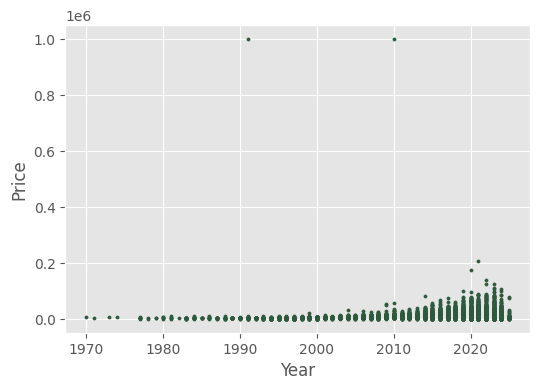

In [59]:
fig = plt.figure(figsize=(6,4))
plt.scatter(train_csv['year'], train_csv['price'], c='#2D5A3CFF', s=5)
plt.xlabel('Year')
plt.ylabel('Price')
plt.style.use('ggplot')

This plot clearly shows there are two outliers with price ~1,000,000.
Identifying and removing them from this plot.

In [61]:
train_csv[['price']].sort_values(by='price', ascending=False)[:5]

,price
508,1000000.0
5789,999999.0
3064,207000.0
1400,173000.0
2436,138900.0


Removing the outliers with index 508 and 5789

In [63]:
df2 = train_csv[['year', 'price']].drop(index=[508, 5789], axis=0)
df2.shape

(7476, 2)

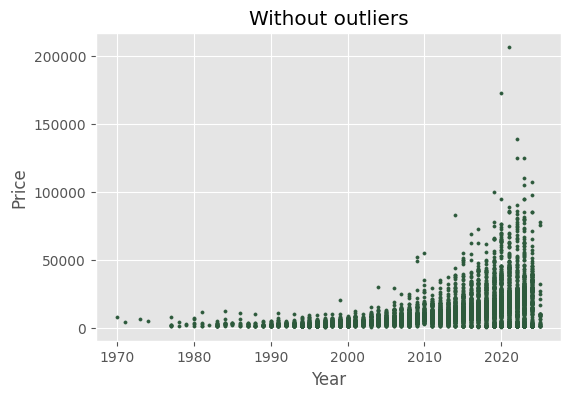

In [64]:
fig = plt.figure(figsize=(6,4))
plt.scatter(df2['year'], df2['price'], c='#2D5A3CFF', s=5)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Without outliers')
plt.style.use('ggplot')

The plot shows that there is some positive correlation between year and price.

### kilometers

In [65]:
train_csv['kilometers'].describe()

count         7471
unique          23
top       +200,000
freq          1349
Name: kilometers, dtype: object

In [70]:
# train_csv['kilometers'].value_counts().reset_index().sort_values(by='kilometers')

There can be two approaches:
1. Treat as categorical and apply One Hot Encoding
2. Take the mid value for each bucket and convert to int

Validate the kilometers values for New Cars - should be low

In [91]:
df = train_csv[['condition', 'kilometers']].groupby(['condition', 'kilometers']).agg({
    'kilometers': 'count'
})
df

kilometers
condition kilometers                   
New       0                         348
          1 - 999                    23
Used      +200,000                 1349
          1,000 - 9,999             201
          10,000 - 19,999           412
          100,000 - 109,999         537
          110,000 - 119,999         307
          120,000 - 129,999         273
          130,000 - 139,999         259
          140,000 - 149,999         249
          150,000 - 159,999         293
          160,000 - 169,999         226
          170,000 - 179,999         210
          180,000 - 189,999         180
          190,000 - 199,999         322
          20,000 - 29,999           358
          30,000 - 39,999           283
          40,000 - 49,999           295
          50,000 - 59,999           241
          60,000 - 69,999           220
          70,000 - 79,999           259
          80,000 - 89,999           286
          90,000 - 99,999           340

### body_type

In [92]:
train_csv['body_type'].describe()

count      7475
unique        7
top       Sedan
freq       3994
Name: body_type, dtype: object

In [93]:
train_csv['body_type'].value_counts()

body_type
Sedan          3994
SUV            1788
HatchBack       760
PickUp          430
Bus - Van       343
Coupe           118
Convertible      42
Name: count, dtype: int64

### num_of_seats

In [95]:
train_csv['num_of_seats'].value_counts()

num_of_seats
5              5839
4               929
7               368
2               151
6                75
3                36
8                30
More than 9      28
9                16
Name: count, dtype: int64

This feature can be converted to numeric. We can combine 'More than 9' with 9.

### fuel

In [96]:
train_csv['fuel'].describe()

count         7471
unique           6
top       Gasoline
freq          4070
Name: fuel, dtype: object

In [97]:
train_csv['fuel'].value_counts()

fuel
Gasoline            4070
Hybrid              1284
Electric            1233
Diesel               590
Plug-in - Hybrid     165
Mild Hybrid          129
Name: count, dtype: int64

### No. of Unique values by features

In [104]:
train_csv.columns

Index(['id', 'scraped_time', 'condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range', 'price'],
      dtype='object')

In [121]:
X_features = ['condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range']
nunique_feature = {'Feature' : [],
                   'Unique_Count' : []}
for feature in X_features:
    nunique_feature['Feature'].append(feature)
    nunique_feature['Unique_Count'].append(len(train_csv[feature].unique()))

In [123]:
nunique_feature_df = pd.DataFrame(nunique_feature)

In [124]:
nunique_feature_df.sort_values(by='Unique_Count', ascending=False, inplace=True)
nunique_feature_df

,Feature,Unique_Count
26,technology_options,4272
25,exterior_options,3940
24,interior_options,3251
3,trim,547
2,model,513
21,neighborhood,474
1,car_make,75
4,year,54
27,description_score,32
12,interior_color,24


We need to take a detailed look at technology_options, exterior_options, interior_options, neighborhood as they have very high cardinality.

We already looked at model, trim, car_make - we need to encode the values which are more frequent.



Let's quickly look at description_score, interior_color, exterior_color.

### description_score

Description Score - Score (0–100) representing the completeness of the seller’s description.

In [127]:
train_csv['description_score'].value_counts()

description_score
فحص كامل    1343
7            637
3            404
4            341
2            251
1             13
6              3
60             3
1500           3
20002          2
20217          2
867            1
20062          1
20264          1
5              1
3600           1
3820007        1
20143          1
20073          1
400007         1
15             1
20254          1
18002          1
1007           1
18004          1
24             1
82             1
28             1
2013           1
2006           1
20182          1
Name: count, dtype: int64

The values seem incorrect as they are not in the 0-100 range.

I will drop this column.

### interior_color

In [131]:
train_csv['interior_color'].describe()

count      7473
unique       23
top       Black
freq       2884
Name: interior_color, dtype: object

In [132]:
train_csv['interior_color'].value_counts()

interior_color
Black          2884
Beige          1241
Nardo Grey      814
Grey            721
White           468
Brown           263
Silver          206
Red             174
Blue            145
Burgundy        109
Navy Blue        90
Bronze           78
Tan              73
Green            60
Orange           49
Baby Blue        34
Petrol           18
Olive Green      16
Gold             15
Yellow            7
Turquoise         4
Purple            3
Pink              1
Name: count, dtype: int64

### exterior_color

In [133]:
train_csv['exterior_color'].value_counts()

exterior_color
White          1592
Black          1384
Silver          982
Grey            826
Nardo Grey      439
Navy Blue       380
Blue            322
Burgundy        276
Red             251
Green           180
Gold            132
Bronze          122
Baby Blue       116
Brown           104
Olive Green      88
Petrol           75
Beige            64
Tan              43
Yellow           38
Turquoise        27
Orange           19
Purple           11
Pink              2
Name: count, dtype: int64

interior_color and exterior_color look ok.

### neighborhood

In [134]:
train_csv['neighborhood'].describe()

count                    7478
unique                    474
top       Al mantika Al Hurra
freq                      546
Name: neighborhood, dtype: object

In [135]:
train_csv['neighborhood'].value_counts()

neighborhood
Al mantika Al Hurra          546
Sports City                  440
Tabarboor                    356
Jubaiha                      275
Other                        198
                            ... 
Al-Mabruka                     1
Bowaydet Al Hawamdeh           1
Sabha                          1
Mojamma' Alshaikh Khaleel      1
Shafa Al-Amriya                1
Name: count, Length: 474, dtype: int64

I think we can try encoding all values first and then just the top neighborhoods by count.

### technology_options, exterior_options, interior_options

In [136]:
train_csv[['technology_options', 'exterior_options', 'interior_options']].head()

,technology_options,exterior_options,interior_options
0,"Remote Start, Cruise Control, Radar, Navigatio...","Panoramic Roof, Electrically Folding Mirrors, ...","Airbags, Air Condition, Electric Seat Control,..."
1,ABS Brakes,"Rim Wheels, Electric Mirrors","Airbags, Center Lock, Air Condition, Alarm Sys..."
2,"Media Screen, ABS Brakes, Rear Camera, Tractio...","Spare Tyre, Rim Wheels, Electrically Folding M...","Airbags, Steering Wheel Controls, Electric Win..."
3,"Traction Control, Cruise Control, Tyre Pressur...","Electrically Folding Mirrors, Electric Mirrors...","Electric Seat Control, Air Condition, AUX / US..."
4,"Bluetooth, Auto Lock System, Traction Control","Rear Sensors, Electric Mirrors, Daytime Runnin...","Steering Wheel Controls, Electric Windows, Cen..."


As these 3 features have multiple values for each row, we need to explode them and transform as one hot encoding.

# Splitting Training data into Train and Test sets

In [138]:
y = train_csv['price']
cols_to_drop = ['price', 'scraped_time', 'id', 'technology_options', 'exterior_options', 'interior_options', 'description_score']
X = train_csv.drop(columns=cols_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [139]:
print(X_train.shape, y_train.shape,'\n', X_test.shape, y_test.shape)

(5608, 26) (5608,) 
 (1870, 26) (1870,)


# Baseline Model

In [152]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [155]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_encoder, selector(dtype_include='object'))
    ],
    remainder='passthrough'
)

Linear Regression

In [160]:
lr_pipe = make_pipeline(preprocessor, LinearRegression())

Random Forest

In [156]:
rf_pipe = make_pipeline(preprocessor, RandomForestRegressor())
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F8E88B260>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [157]:
y_pred = rf_pipe.predict(X_test)

In [159]:
score = root_mean_squared_error(y_test, y_pred)
print(f'RMSE score for the RF model is {score:.2f}')

RMSE score for the RF model is 8611.97


In [162]:
rf_cv = cross_val_score(rf_pipe, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
rf_cv

array([-15281.86406452,  -8077.1065653 , -30844.68928739, -22779.52318645,
       -30723.5872781 ])

# Submission Prediction

In [163]:
rf_pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F8E88B260>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [165]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(4027, 32)

In [167]:
test_df.rename(columns=cols_map, inplace=True)

In [170]:
cols_to_drop = ['scraped_time', 'id', 'technology_options', 'exterior_options', 'interior_options', 'description_score']
test_df_X = test_df.drop(columns=cols_to_drop)